In [61]:
# description:
#  - command line script uses FA12:runofftools library to generate monthly
#    climatology in rivers_month_202101GO.nc (no gauge data)
#  - notebook inspects this file and compares to the one prepared for 500m
#          checks runoff locations and runoff total flux values. 
#          see diagram of runofftools library in notes (PPT).

# log
#  2021-04
#  - regenerated the monthly file using new meshmask and updated runofftools
#    code
#  - links and data updated to new folder
# - success matching flux between two sources
#  2020-01
#  - added suggested code from MD:
#    sum(e1t*e2t*tmask*runoff) (should be the same on Susan’s grid 
#     and on our grid)
#  - look for cells where (1-tmask)*runoff is nonzero and those 
#    values need to be moved to water cells.
#  
# in: 
#   1) coordinates_salishsea_1500m.nc
#   2) bathy_salishsea_1500m_20210205.nc
#   3) rivers_month_20210406_GO.nc (generated by make_climatology script)
#   4) mesh_mask_salishsea_1500m_20210225.nc (generated by NEMO)
#   5) rivers_month_201702MD.nc (river climatol. from higher resolution 500m model)
#   6) rivers_month_202101GO.nc (river climatol. used here)
#
# out: 
#   1) manual edits to the make_climatology script
#   2) stats that compare total runoff flux

In [1]:
%matplotlib notebook
import netCDF4 as nc

import numpy as np
from helpers import writebathy, expandf
from helpers import gete1, gete2, writecoords, t2u, t2v, t2f
import matplotlib.pyplot as plt
import scipy.io as sio

np.set_printoptions(threshold=np.inf)

NEMO_mesh_mask = '..//data//mesh mask//mesh_mask_20210406.nc'
NEMO_mesh_mask500m = '..//data//mesh mask//etc//mesh_mask201702MD.nc'
bathy_file = '..//data//bathymetry//bathy_salishsea_1500m_20210406.nc'
monthlyrivers_file = '..//data//runoff//rivers_month_20210406_GO.nc'
monthlyrivers500m_file = '..//data//runoff//etc//rivers_month_201702MD.nc'
NEMOgrid_file = '..//data//grid//coordinates_salishsea_1500m.nc'


In [2]:
# helper functions

# load runoff 
def load1(f):
    with nc.Dataset(f) as ncid:
        # grabbing flux for all months (to do: make loop)
        rorunoff = (ncid.variables["rorunoff"][0, :, :].filled() + 
                    ncid.variables["rorunoff"][1, :, :].filled() + 
                    ncid.variables["rorunoff"][2, :, :].filled() + 
                    ncid.variables["rorunoff"][3, :, :].filled() +
                    ncid.variables["rorunoff"][4, :, :].filled() +
                    ncid.variables["rorunoff"][5, :, :].filled() +
                    ncid.variables["rorunoff"][6, :, :].filled() +
                    ncid.variables["rorunoff"][7, :, :].filled() +
                    ncid.variables["rorunoff"][8, :, :].filled() +
                    ncid.variables["rorunoff"][9, :, :].filled() +
                    ncid.variables["rorunoff"][10, :, :].filled() +
                    ncid.variables["rorunoff"][11, :, :].filled())
        
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()

    return rorunoff, latt, lont

# load mask (tmask)
def load2(f):
    with nc.Dataset(f) as ncid:
        tmask = ncid.variables["tmask"][0,0,:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        e1t = ncid.variables["e1t"][0,:, :].filled()
        e2t = ncid.variables["e2t"][0,:, :].filled()

    return tmask, latt, lont, e1t, e2t

# bathy mask
# (temp for creating mask from bathy - should use NEMO mesh mask if avail)
def load3(f):
    with nc.Dataset(f) as ncid:
        depth = ncid.variables["Bathymetry"][:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()

    return depth, latt, lont

# coords mask
def load4(f):
    with nc.Dataset(f) as ncid:
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        e1t = ncid.variables["e1t"][0,:, :].filled()
        e2t = ncid.variables["e2t"][0,:, :].filled()

    return latt, lont, e1t, e2t

def plotrunoff1(f):
    rorunoff, latt, lont = load1(f)
    
    #print(rorunoff.shape)
    #print(np.sum(rorunoff))
    ma_rorunoff = np.ma.masked_array(rorunoff, rorunoff > 0)
    
    plt.figure(figsize=(8,8))
    plt.subplot(1,1,1)
    plt.pcolormesh(ma_rorunoff, cmap=plt.pink()); plt.title("rorunoff")

    plt.tight_layout()
    plt.savefig("runoffcheck1.png")

# plot runoff cells that are on land
def plotrunoff2(mask, runoff):
    
    rorunoff, latt, lont = load1(runoff)
    ma_rorunoff = np.ma.masked_array(rorunoff, rorunoff == 0)
    
    # rename umaskutil
    umaskutil, latt, lont, e1t, e2t = load2(mask)
    
    # bathy (if no mesh mask)
    #depth, latt, lont = load3(mask)
    # having trouble with masked arrays, so make inverted array (land = 0, marine = 1)
    #depth[depth>0]=1
    #depth[depth<1]=0
    #depth[depth==1]=2
    #depth[depth==0]=1
    #depth[depth==2]=0
    #ma_depth=depth
    #check_bad = depth*ma_rorunoff
    
    check_bad = (1-umaskutil) * ma_rorunoff
    #check[check==0]=np.nan
    ma_check_bad = np.ma.masked_array(check_bad, check_bad == 0)
    
    # 2021-04-06
    check_bad2 = np.where(np.logical_and(rorunoff > 0, umaskutil == 0))
    print(check_bad2)
    
#     # print indices of bad
#     print(ma_check_bad.shape)
#     i = 0 
#     j = 0 
#     count = 0 
#     for i in range(0,ma_check_bad.shape[0]): 
#         for j in range(0, ma_check_bad.shape[1]):
#             if ma_check_bad[i,j] > 0:
#                 print(str(i) + "," + str(j))
#                 count += 1
#             j += 1
#         i += 1
    
#     print("number of runoff cells on land")
#     print(count)
    
#     check_good = (umaskutil)*ma_rorunoff
#     ma_check_good = np.ma.masked_array(check_good, check_good == 0)

#     plt.figure(figsize=(8,8))
#     plt.subplot(1,1,1)
#     #plt.pcolormesh(lont,latt, depth, cmap=plt.plasma()); plt.colorbar(); plt.title("depth")
#     plt.pcolormesh(ma_check_bad, cmap=plt.pink()); plt.title("check bad")
#     #plt.pcolormesh(ma_check_good, cmap=plt.pink()); plt.title("check good")
#     #plt.pcolormesh(ma_depth, cmap=plt.pink()); plt.title("depth mask")
#     #plt.pcolormesh(ma_rorunoff, cmap=plt.pink()); plt.title("runoff")

#     plt.tight_layout()
#     #plt.savefig(f.replace(".nc","_bathycheck.png"))
#     #plt.savefig("C:/temp/runofftools/runoffcheck_depthmask_20210122.png")
#     #plt.savefig("C:/temp/runofftools/runoffcheck_runoffbad_20210122.png")
#     #plt.savefig("C:/temp/runofftools/runoffcheck_runoffgood_20210122.png")
    
    
def plotmask(f):
    tmask, latt, lont, e1t, e2t = load2(f)
    
    print(tmask.shape)
  
    plt.figure(figsize=(8,8))
    plt.subplot(1,1,1)
    plt.pcolormesh(tmask[:,:], cmap=plt.pink()); plt.title("model_mask")

    plt.tight_layout()
    plt.savefig("maskcheck.png")
    
def plotbathy(f):
    depth, latt, lont = load3(f)
    
    print(depth.shape)
    ma_depth = np.ma.masked_array(depth, depth == 0)
    
    plt.figure(figsize=(8,8))
    plt.subplot(1,1,1)
    plt.pcolormesh(ma_depth, cmap=plt.plasma()); plt.colorbar(); plt.title("Bathymetry")

    plt.tight_layout()
    #plt.savefig(f.replace(".nc","_bathycheck.png"))
    #plt.savefig("C:/temp/runofftools/runoffcheck2.png")

# check total runoff is same between two resolutions  
# sum(e1t*e2t*tmask*runoff)
def checkrunoffvs500m(mask1, coords1, mask2, ro1, ro2):
    
    # using 1500 m bathy in lieu of mask
    tmask1, latt, lont, e1t_1, e2t_1 = load2(mask1)
    
    #tmask1, latt, lont = load3(mask1)
    latt, lont, e1t_1, e2t_1 = load4(coords1)
    
    # trouble with masked arrays (behaviour of masked 
    # empty vs null vs np.nan) so doing this
    tmask1[tmask1>0]=1
    tmask1[tmask1<1]=0
    tmask1_1 = np.ma.masked_array(tmask1, tmask1 == 0)
    tmask1_1[tmask1_1 != 1] = 0
    
    rorunoff1, latt, lont = load1(ro1)
    print(round(np.sum(e1t_1 * e2t_1 * rorunoff1)))
    
    tmask2, latt, lont, e1t_2, e2t_2 = load2(mask2)  
    rorunoff2, latt, lont = load1(ro2)
    print(round(np.sum(e1t_2 * e2t_2 * rorunoff2)))
    
    # shape check
    print(rorunoff1.shape)
    print(rorunoff2.shape)
    print(tmask1.shape)
    print(tmask2.shape)
    print(e1t_1.shape)
    print(e2t_1.shape)
    print(e1t_2.shape)
    print(e2t_2.shape)
    
    # should be nearly the same
    print(np.sum(tmask1))
    print(round(np.sum(e1t_1 * e2t_1 * tmask1_1 * rorunoff1)))
    print(round(np.sum(e1t_2 * e2t_2 * tmask2 * rorunoff2)))


In [3]:
# check that total runoff flux is same / similar between the two resolutiosn
checkrunoffvs500m(#bathy_file, # mask 1
                  NEMO_mesh_mask, # mask 1    
                  NEMOgrid_file, 
                  NEMO_mesh_mask500m, # mask 2
                  monthlyrivers_file, 
                  monthlyrivers500m_file)

91609576.0
91908300.0
(299, 132)
(898, 398)
(299, 132)
(898, 398)
(299, 132)
(299, 132)
(898, 398)
(898, 398)
9381
91609576.0
91908300.0


<IPython.core.display.Javascript object>


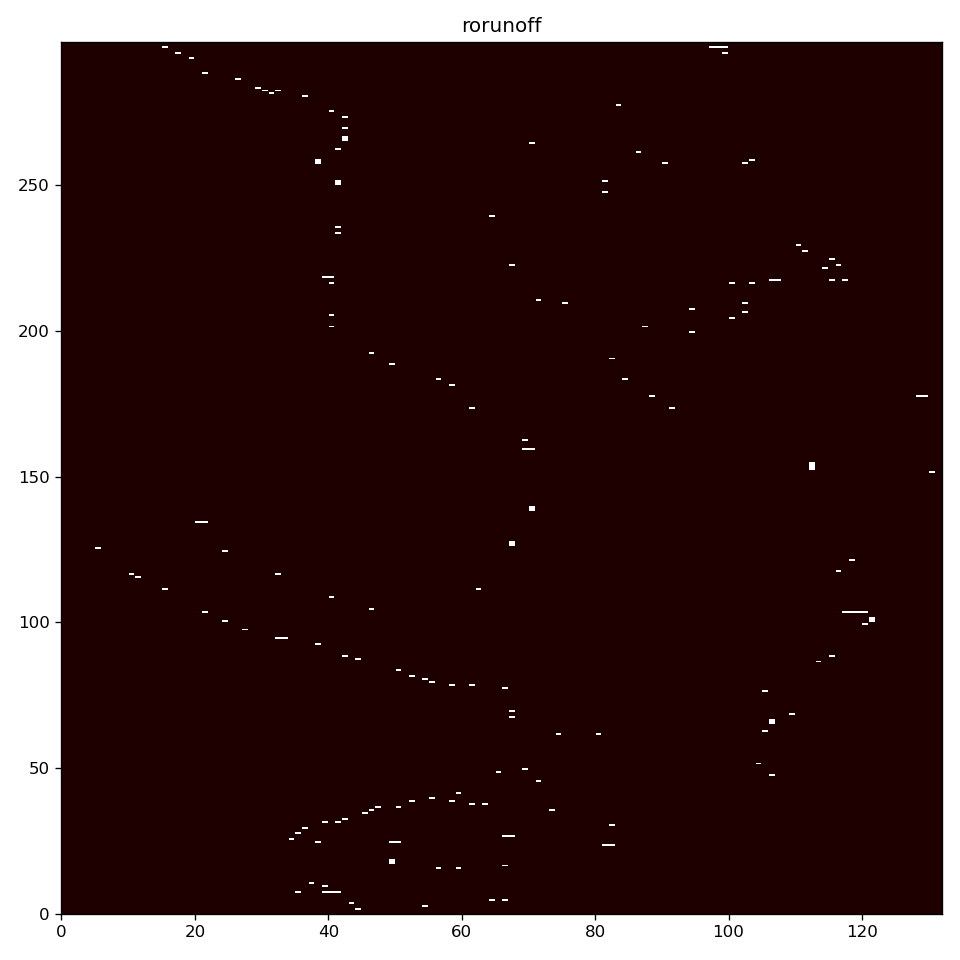

In [4]:
plotrunoff1(monthlyrivers_file)

In [5]:
# should be empty map if no runoff cells on land
#plotrunoff2(bathy_file, monthlyrivers_file)
plotrunoff2(NEMO_mesh_mask, monthlyrivers_file)

(array([], dtype=int64), array([], dtype=int64))


(299, 132)


<IPython.core.display.Javascript object>


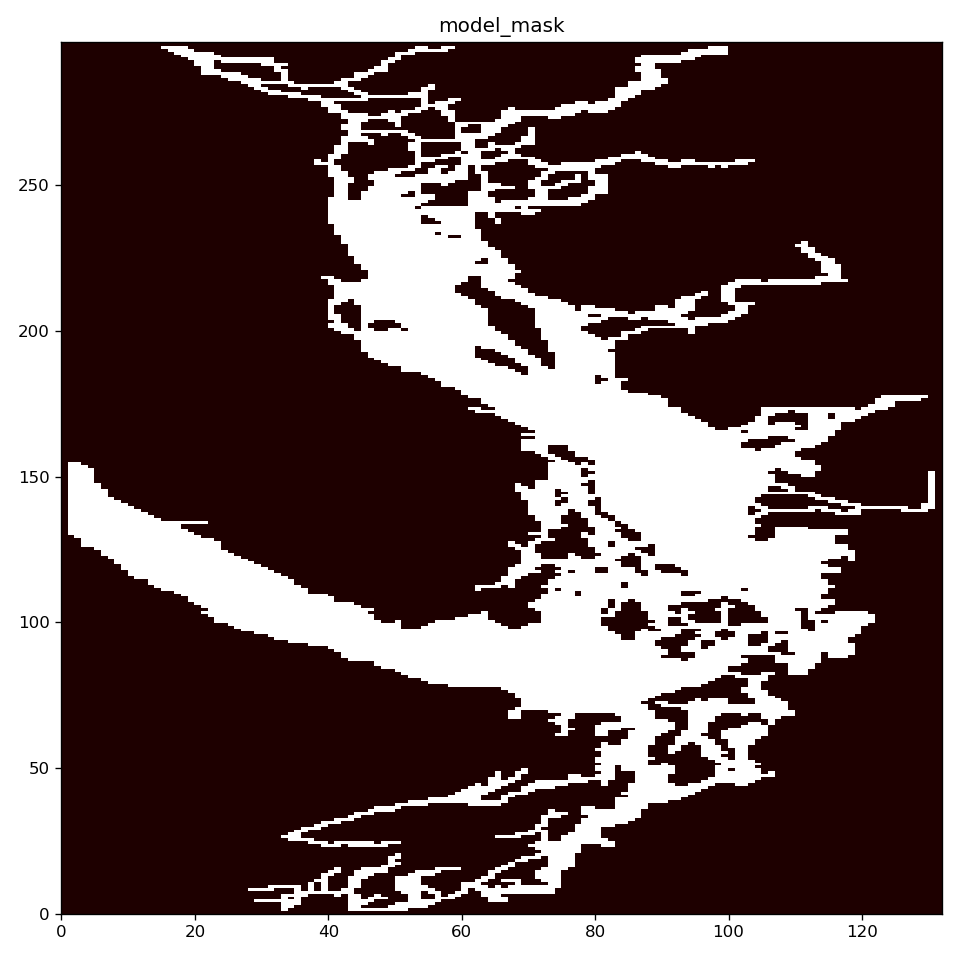

In [6]:
plotmask(NEMO_mesh_mask)

<IPython.core.display.Javascript object>


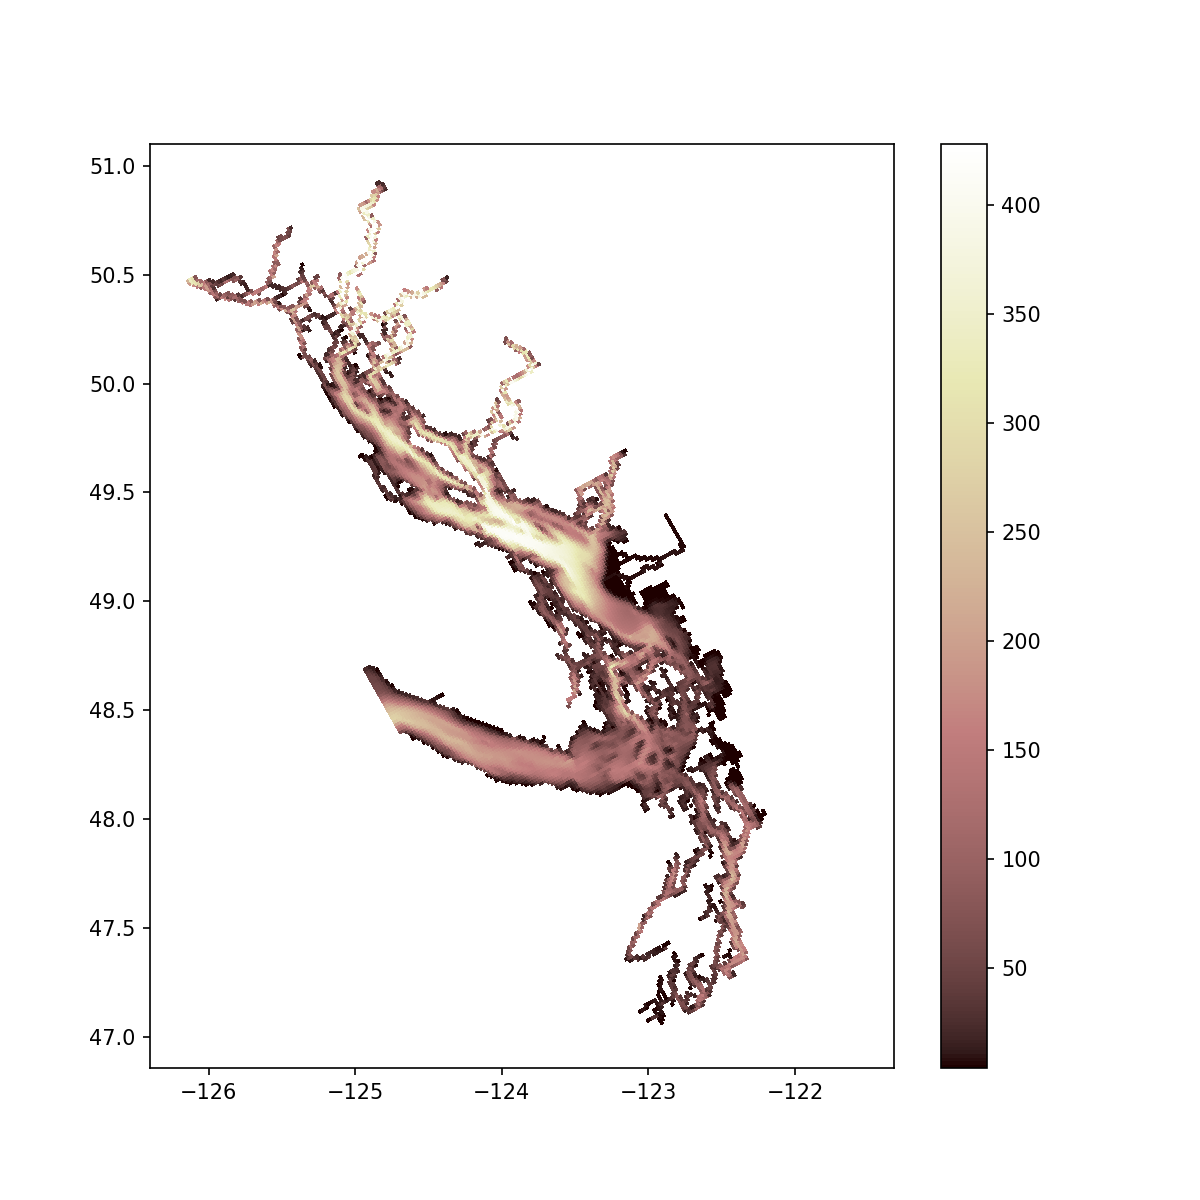

In [25]:
#gridfilename = 'coordinates_salishsea_1500m.nc'
#bathyfilename = 'bathy_salishsea_1500m_before_manual_edits.nc'
#bathyfilename = 'bathy_salishsea_1500m_Dec30.nc'

with nc.Dataset(NEMOgrid_file) as ncid:
    glamt = ncid.variables["glamt"][0, :, :].filled()
    gphit = ncid.variables["gphit"][0, :, :].filled()
    glamf = ncid.variables["glamf"][0, :, :].filled()
    gphif = ncid.variables["gphif"][0, :, :].filled()

glamfe,gphife=expandf(glamf,gphif)

with nc.Dataset(bathy_file) as nc_b_file:
    bathy = nc_b_file.variables["Bathymetry"][:, :].filled()

bb=np.copy(bathy); bb[bb==0]=np.nan
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.pcolormesh(glamfe,gphife,bb); plt.colorbar()
# Coastlines
#mfile = sio.loadmat('PNW.mat')
#ncst = mfile['ncst']
#plt.plot(ncst[:,0],ncst[:,1],'k')

#mfile2 = sio.loadmat('PNWrivers.mat')
#ncst2 = mfile2['ncst']
#plt.plot(ncst2[:,0],ncst2[:,1],'k')